In [ ]:
import os, warnings
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers

from keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import mean_absolute_error, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib

In [ ]:
# https://www.kaggle.com/datasets/samuelcortinhas/apples-or-tomatoes-image-classification

In [ ]:
# Устанавливаем seed для процессов
def set_seed(seed=31415):
    np.random.seed(seed) # seed для numpy
    tf.random.set_seed(seed) # seed для tf
    os.environ['PYTHONHASHSEED'] = str(seed) # seed для hash-функций
    os.environ['TF_DETERMINISTIC_OPS'] = '1' # seed для операция tf

set_seed()

# Преобразует изображение в float
# Значение пикселей будет в диапазоне [0, 1]
# Нужно для нормализации данных
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [ ]:
def plot_metric(history, metric, title, ylabel, save_path=None):
    plt.figure(figsize=(5, 3))
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    if save_path:
        plt.savefig(save_path)
        print(f"{title} saved to {save_path}")

    plt.show()

def get_plot(history, save_path=None):
    warnings.filterwarnings("ignore")

    accuracy_save_path = save_path + '_accuracy.png' if save_path else None
    loss_save_path = save_path + '_loss.png' if save_path else None

    plot_metric(history, 'binary_accuracy', 'Model Accuracy', 'Accuracy', accuracy_save_path)
    plot_metric(history, 'loss', 'Model Loss', 'Loss', loss_save_path)

def get_confusion_matrix(model, ds_valid, save_path=None):
    y_true = []
    y_pred = []

    for images, labels in ds_valid:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((predictions > 0.5).astype(int))

    # Преобразуем списки в массивы NumPy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Вычисляем матрицу ошибок
    cm = confusion_matrix(y_true, y_pred)

    # Отображаем матрицу ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")

    plt.show()


def calculate_f1_score(model, ds_valid, save_path=None):
    y_true = []
    y_pred = []

    for images, labels in ds_valid:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((predictions > 0.5).astype(int))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    f1 = f1_score(y_true, y_pred)

    if save_path:
        plt.figure(figsize=(6, 4))
        plt.text(0.5, 0.5, f'F1 Score: {f1:.4f}', fontsize=20, ha='center', va='center')
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()

    return f1

In [ ]:
directory = '/content/drive/MyDrive/appletomato'

train_dir = os.path.join(directory, 'train')
validation_dir = os.path.join(directory, 'test')

train_apple_dir = os.path.join(train_dir, 'apples')
train_tomato_dir = os.path.join(train_dir, 'tomatoes')

validation_apple_dir = os.path.join(validation_dir, 'apples')
validation_tomato_dir = os.path.join(validation_dir, 'tomatoes')

In [ ]:
print(f'TRAIN Яблочных изображений: {len(os.listdir(train_apple_dir))}')
print(f'TRAIN Томатных изображений: {len(os.listdir(train_tomato_dir))}\n')

print(f'TEST Яблочных изображений: {len(os.listdir(validation_apple_dir))}')
print(f'TEST Томатных изображений {len(os.listdir(validation_tomato_dir))}')

TRAIN Яблочных изображений: 164
TRAIN Томатных изображений: 130

TEST Яблочных изображений: 54
TEST Томатных изображений 43


In [1]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

def load_random_images(directory, k=4):
    return [os.path.join(directory, name) for name in random.sample(os.listdir(directory), k=k)]

apple_images = load_random_images(train_apple_dir)
tomato_images = load_random_images(train_tomato_dir)
all_images = apple_images + tomato_images

for i, img_path in enumerate(all_images):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Создаёт объект датасета Keras

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train_ = image_dataset_from_directory(
    train_dir,
    labels='inferred', # извлекает метки из названия папок
    label_mode='binary', # метки бинарные (только 2 класса)
    image_size=[128, 128], # вот тут по умолчанию 128, можно поэксперементировать
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_valid_ = image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)


ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 294 files belonging to 2 classes.
Found 97 files belonging to 2 classes.


**МОДЕЛЬ 1**

In [ ]:
model_1 = keras.Sequential([

    # Сверточный слой фильтрами, размер ядра 5х5
    # Функция активации РеЛу, padding (итоговое изобр имеет те же размеры, что и входное)
    # Форма выходных данных 128х128, 3 канала RGB
    layers.Conv2D(filters=4, kernel_size=5, activation="relu", padding='same', input_shape=[128, 128, 3]),

    # Пулинг для уменьшения размерности итоговых данных
    layers.MaxPool2D(),

    # Аналогично, но меняет ильтры и размер ядра
    layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Третий сверточный
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Многомерный массив (тензор) - в одномерный
    # Полносвязный слой с 6 нейронами и ReLu
    # Выходной слой с 1 нейроном и сигмой в активации (выход от 0 до 1 - бинарное)
    layers.Flatten(),
    layers.Dense(units=6, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),

])

# компиляция модели
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01), # оптимизатор Adam
    loss='binary_crossentropy', # ф-я потерь
    metrics=['binary_accuracy'] # метрика для оценки - бинарная точность
)

In [ ]:
# обзор модели
# model_1.summary()

In [ ]:
# обучаем модель
history_1 = model_1.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=25,
    verbose=0,
)

Model Accuracy saved to model_1/plot_1_accuracy.png


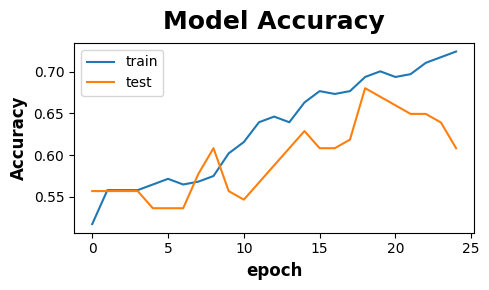

Model Loss saved to model_1/plot_1_loss.png


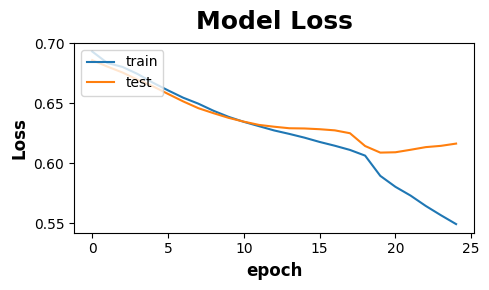

In [ ]:
get_plot(history_1, 'model_1/plot_1')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Confusion matrix saved to model_1/matrix_1


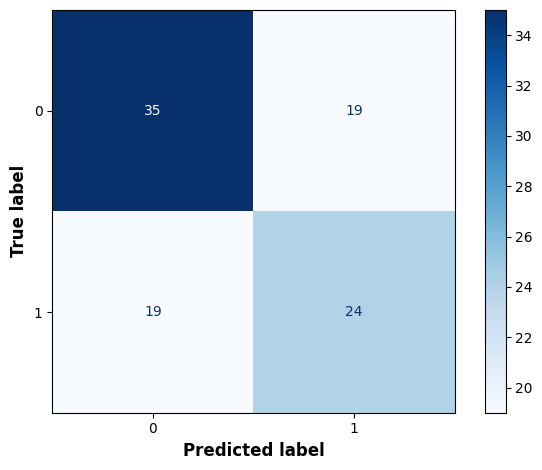

In [ ]:
get_confusion_matrix(model_1, ds_valid, 'model_1/matrix_1')

In [ ]:
f1 = calculate_f1_score(model_1, ds_valid, 'model_1/f1_1')
print(f"F1 Score: {f1:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
F1 Score: 0.5581


In [ ]:
joblib.dump(model_1, "model_1/model_1.pkl")
model_1 = joblib.load("model_1/model_1.pkl")

**МОДЕЛЬ 2**

In [ ]:
# building a small model
model_2 = tf.keras.models.Sequential([

    # Входной слой и нормализация
    tf.keras.Input(shape=(128, 128, 3)),
    tf.keras.layers.Rescaling(1./255),

    # Первый свёрточный слой
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Второй свёрточный слой
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Третий свёрточный слой
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # # Преобразование в плоский вектор
    tf.keras.layers.Flatten(),

    # Полносвязный слой
    tf.keras.layers.Dense(256, activation='relu'),

    # Выходной слой
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
model_2.compile(optimizer='adam',
                loss='binary_crossentropy',  # Для бинарной классификации
                metrics=['binary_accuracy'])


In [ ]:
# обзор модели
# model_2.summary()

In [ ]:
history_2 = model_2.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=25,
    verbose=0,
)

Model Accuracy saved to model_2/plot2_accuracy.png


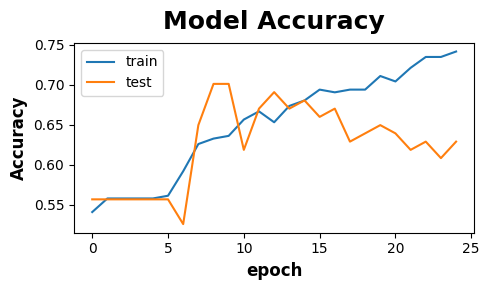

Model Loss saved to model_2/plot2_loss.png


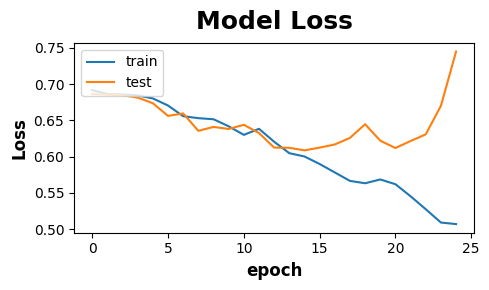

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Confusion matrix saved to model_2/matrix_2


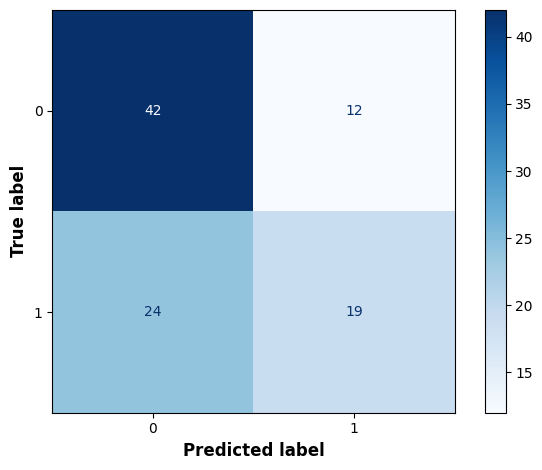

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
F1 Score: 0.5135


In [ ]:
get_plot(history_2, 'model_2/plot2')
get_confusion_matrix(model_2, ds_valid, 'model_2/matrix_2')
f1 = calculate_f1_score(model_2, ds_valid, 'model_2/f1_2')
print(f"F1 Score: {f1:.4f}")

In [ ]:
joblib.dump(model_2, "model_2/model_2.pkl")
model_2 = joblib.load("model_2/model_2.pkl")

**МОДЕЛЬ 3**

In [ ]:
# Определение размеров входных изображений
input_shape = (128, 128, 3)  # Пример: изображения 128x128 с 3 каналами (RGB)
num_classes = 1  # Для бинарной классификации

# building a small model with Dropout
model_3 = tf.keras.models.Sequential([

    # Входной слой и нормализация
    tf.keras.Input(shape=(128, 128, 3)),
    tf.keras.layers.Rescaling(1./255),

    # Первый свёрточный слой
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),  # Dropout после первого свёрточного слоя

    # Второй свёрточный слой
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),  # Dropout после второго свёрточного слоя

    # Третий свёрточный слой
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),  # Dropout после третьего свёрточного слоя

    # Преобразование в плоский вектор
    tf.keras.layers.Flatten(),

    # Полносвязный слой
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout после полносвязного слоя

    # Выходной слой
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
model_3.compile(optimizer='adam',
                loss='binary_crossentropy',  # Для бинарной классификации
                metrics=['binary_accuracy'])

In [ ]:
# Обзор модели
# model_3.summary()

In [ ]:
# Определение колбэка для ранней остановки
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Метрика для мониторинга
    patience=7,                     # Количество эпох без улучшения
    verbose=1,                      # Выводить сообщения
    mode='max',                     # Ожидаемое поведение: максимизация метрики
    restore_best_weights=True       # Восстановить лучшие веса модели
)

In [ ]:
history_3 = model_3.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=25,
    verbose=0,
    callbacks=[early_stopping]
)

Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 9.


Model Accuracy saved to model_3/plot_3_accuracy.png


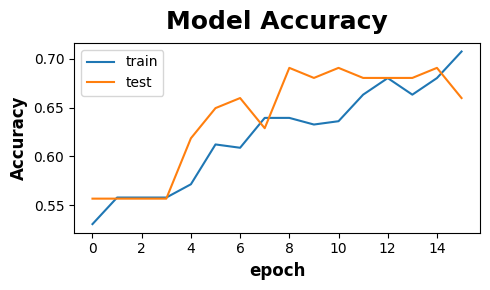

Model Loss saved to model_3/plot_3_loss.png


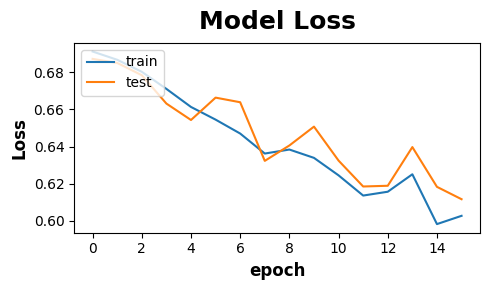

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Confusion matrix saved to model_3/matrix_3


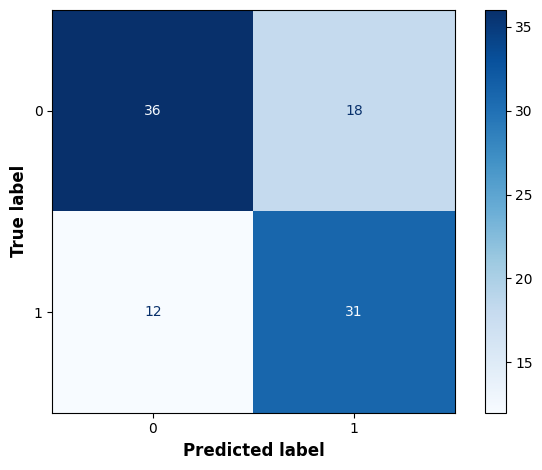

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
F1 Score: 0.6739


In [ ]:
get_plot(history_3, 'model_3/plot_3')
get_confusion_matrix(model_3, ds_valid, 'model_3/matrix_3')
f1 = calculate_f1_score(model_3, ds_valid, 'model_3/f1_3')
print(f"F1 Score: {f1:.4f}")

In [ ]:
joblib.dump(model_3, "model_3/model_3.pkl")
model_3 = joblib.load("model_3/model_3.pkl")